#Paquetes necesarios

Podremos hacer uso del mismo *environment* de la primera práctica, aunque en ocasiones pedirá instalar Pillow

In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

Carga imagen desde archivo y convierte a RGB

TAREA: Realiza la cuenta de píxeles blancos por filas (en lugar de por columnas). Determina el valor máximo de píxeles blancos para filas, maxfil, mostrando el número de filas y sus respectivas posiciones, con un número de píxeles blancos mayor o igual que 0.90*maxfil.

(0.0, 512.0)

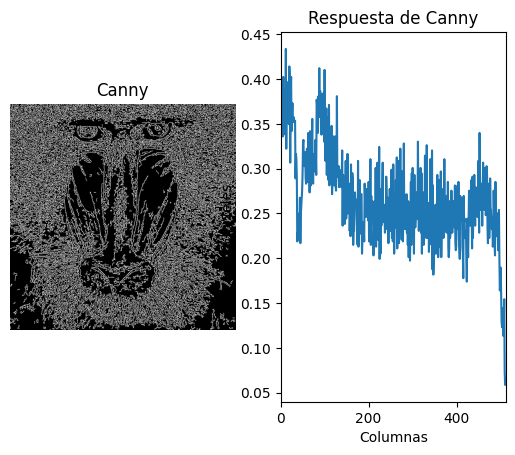

In [8]:
img = cv2.imread('mandril.jpg') 

canny = cv2.Canny(img, 100, 200)
#El contenido de la imagen resultado de Canny, son valores 0 o 255, lo compruebas al descomentar
#print(canny)
#Cuenta el número de píxeles blancos (255) por columna
#Suma los valores de los pixeles por columna
col_counts = cv2.reduce(canny, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
row_counts = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)

#Normaliza en base al número de filas, primer valor devuelto por shape, y al valor máximo del píxel (255)
#El resultado será el número de píxeles blancos por columna
rows = col_counts[:,] / (255 * canny.shape[0])
cols = row_counts[:,] / (255 * canny.shape[1])

#Muestra dicha cuenta gráficamente
plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Canny")
plt.imshow(canny, cmap='gray') 

plt.subplot(1, 2, 2)
plt.title("Respuesta de Canny")
plt.xlabel("Columnas")
plt.ylabel("% píxeles")
plt.plot(cols)
#Rango en x definido por las columnas
plt.xlim([0, canny.shape[0]])

Sobel. Cuando hay un borde, el valor de intensidad de los píxeles cercanos cambia de forma notable, calcular las derivadas proporciona una evidencia de dicho cambio. El operador de Sobel aproxima el cálculo de la derivada aplicando un kernel de tamaño impar basado en el patrón [1 2 1].

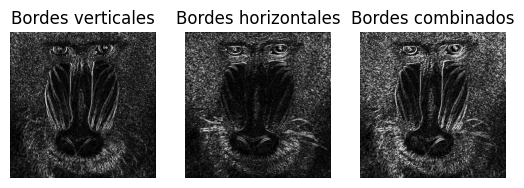

In [6]:
# Gaussiana para suavizar la imagen original, eliminando altas frecuencias
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suavizado con Gaussiana 3x3
ggris = cv2.GaussianBlur(gris, (3, 3), 0)

#Calcula en ambas direcciones (horizontal y vertical)
sobelx = cv2.Sobel(ggris, cv2.CV_64F, 1, 0)  # x
sobely = cv2.Sobel(ggris, cv2.CV_64F, 0, 1)  # y
#Combina ambos resultados
sobel = cv2.add(sobelx, sobely)

#Muestra ambos resultados
plt.figure()
plt.subplot(1, 3, 1)
plt.axis("off")
plt.title('Bordes verticales')
#Verticales
#Para visualizar convierte a escala manejable en una imagen de grises
plt.imshow(cv2.convertScaleAbs(sobelx), cmap='gray') 
#plt.imshow(sobelx, cmap='gray') #Prueba sin convertir escala

plt.subplot(1, 3, 2)
plt.axis("off")
plt.title('Bordes horizontales')
#Horizontales
#Para visualizar convierte a escala manejable en una imagen de grises
plt.imshow(cv2.convertScaleAbs(sobely), cmap='gray') 
#plt.imshow(sobelx, cmap='gray') #Prueba sin convertir escala

plt.subplot(1, 3, 3)
plt.axis("off")
plt.title('Bordes combinados')
#Para visualizar convierte a escala manejable en una imagen de grises
plt.imshow(cv2.convertScaleAbs(sobel), cmap='gray') 
#plt.imshow(sobel, cmap='gray') #Prueba sin convertir escala
plt.show()

Observ que visualizar la imagen resultado de Sobel directamenet como escala de grises produce un resultado diferente. Ha sido necesario convertir a datos de tipo byte. La siguiente celda muestra dos variantes de conversión, con OpenCV y numpy, evidenciando diferencias, además de los valores antes y tras escalar a 8 bits

Tipo de datos, valor mínimo y máximo en sobel: float64, -594.0, 570.0
Tipo de datos, valor mínimo y máximo en sobel8: uint8, 0, 255
Tipo de datos, valor mínimo y máximo en sobel8np: uint8, 0, 254


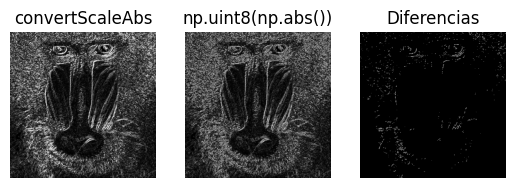

In [7]:
# Mostrar el tipo de dato de los valores en la imagen soble, además de valores máximo y mínimo
print(f"Tipo de datos, valor mínimo y máximo en sobel: {sobel.dtype}, {np.min(sobel)}, {np.max(sobel)}")

# Conversión a byte con openCV
sobel8 = cv2.convertScaleAbs(sobel)
# Mostrar el tipo de dato de los valores en la imagen soble, además de valores máximo y mínimo
print(f"Tipo de datos, valor mínimo y máximo en sobel8: {sobel8.dtype}, {np.min(sobel8)}, {np.max(sobel8)}")

# Conversión a byte con numpy
sobel8np = np.uint8(np.abs(sobel))
# Mostrar el tipo de dato de los valores en la imagen soble, además de valores máximo y mínimo
print(f"Tipo de datos, valor mínimo y máximo en sobel8np: {sobel8np.dtype}, {np.min(sobel8np)}, {np.max(sobel8np)}")

plt.figure()
plt.subplot(1, 3, 1)
plt.axis("off")
plt.title('convertScaleAbs')
plt.imshow(sobel8, cmap='gray') 

plt.subplot(1, 3, 2)
plt.axis("off")
plt.title('np.uint8(np.abs())')
plt.imshow(sobel8np, cmap='gray') 

plt.subplot(1, 3, 3)
plt.axis("off")
plt.title('Diferencias')
plt.imshow(cv2.absdiff(sobel8,sobel8np), cmap='gray') 

plt.show()

Umbralizado de una imagen

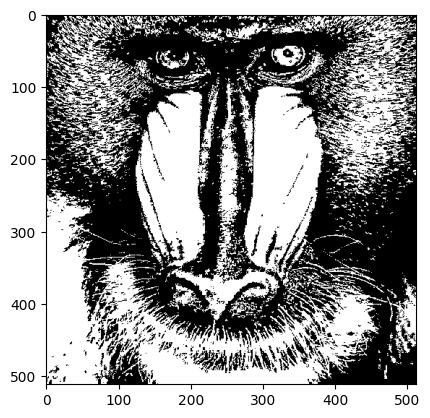

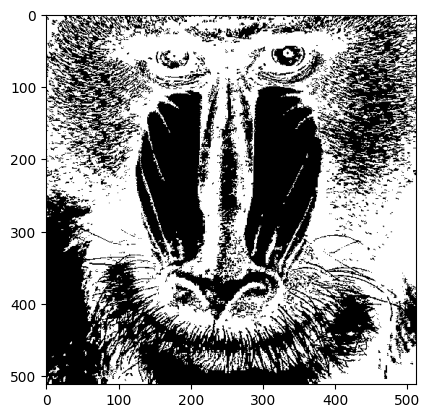

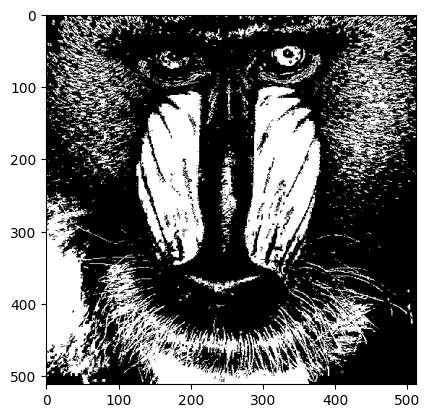

In [8]:
#Define valor umbral
valorUmbral = 130 #Prueba otros valores
#Obtiene imagen umbralizada para dicho valor definido
_, imagenUmbralizada = cv2.threshold(gris, valorUmbral, 255, cv2.THRESH_BINARY)
#Muestra resultado
plt.imshow(imagenUmbralizada, cmap='gray')
plt.show()

#El umbralizado inverso, los valores menores que el umbral se muestran en blanco
_, imagenUmbralizada = cv2.threshold(gris, valorUmbral, 255, cv2.THRESH_BINARY_INV)
#Muestra resultado
plt.imshow(imagenUmbralizada, cmap='gray')
plt.show()

imagenEnRango = cv2.inRange(gris, 150, 200)
#Muestra resultado
plt.imshow(imagenEnRango, cmap='gray')
plt.show()

El histograma de una imagen aporta información sobre el valor de umbral a elegir para ciertas situaciones

(0.0, 256.0)

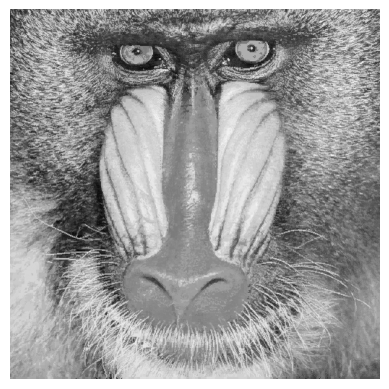

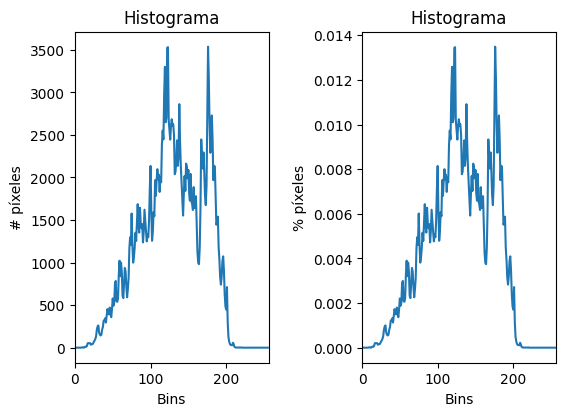

In [20]:
#Cálculo del histograma de una imagen en escala de grises
hist = cv2.calcHist([gris], [0], None, [256], [0, 256])

plt.figure()
plt.axis("off")
plt.imshow(gris, cmap='gray')

# Histograma sin normalizar
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)
plt.xlim([0, 256])

#Normaliza el histograma en base al número de píxeles y lo muestra
hist /= hist.sum()

plt.subplot(1, 2, 2)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("% píxeles")
plt.tight_layout(pad=3.0) #separación entre plots
plt.plot(hist)
plt.xlim([0, 256])

TAREA: Aplica umbralizado a la imagen resultante de Sobel (convertida a 8 bits), y posteriormente realiza el conteo por filas y columnas similar al realizado en el ejemplo con la salida de Canny de píxeles no nulos. Calcula el valor máximo de la cuenta por filas y columnas, y determina las filas y columnas por encima del 0.90*máximo. Remarca con alguna primitiva gráfica dichas filas y columnas sobre la imagen del mandril. ¿Cómo se comparan los resultados obtenidos a partir de Sobel y Canny?

In [22]:
img = cv2.imread('mandril.jpg') 
valorUmbral = 200
_, sobelUmbralizado = cv2.threshold(sobel8, valorUmbral, 255, cv2.THRESH_BINARY)

cuenta_filas = cv2.reduce(sobelUmbralizado, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
cuenta_columnas = cv2.reduce(sobelUmbralizado, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)

valmax_filas = np.max(cuenta_filas)
valmax_columnas = np.max(cuenta_columnas)

umbral_filas = 0.9 * valmax_filas
umbral_columnas = 0.9 * valmax_columnas

filas_determinadas = np.where(cuenta_filas > umbral_filas)[1]
columnas_determinadas = np.where(cuenta_columnas > umbral_columnas)[0]

print(f"Filas determinadas: {filas_determinadas}")
print(f"Columnas determinadas: {columnas_determinadas}")

for fila in filas_determinadas:
    cv2.line(img, (0, fila), (img.shape[1], fila), (0, 255, 0), 2)
for columna in columnas_determinadas:
    cv2.line(img, (columna, 0), (columna, img.shape[0]), (0, 0, 255), 2)

print(f"Filas destacadas: {filas_determinadas}")
# Visualización
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Sobel binarizado")
plt.axis("off")
plt.imshow(sobelUmbralizado, cmap='gray')
plt.subplot(1,2,2)
plt.title("Mandril con filas/columnas destacadas")
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Comparación con Canny
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Conteo columnas (Canny)")
plt.plot(cols)
plt.subplot(1,2,2)
plt.title("Conteo columnas (Sobel)")
plt.plot(cuenta_columnas)
plt.show()

#Comparación de resultados
plt.figure()
plt.title('Sobel umbralizado')
plt.imshow(sobelUmbralizado, cmap='gray')
plt.show()

plt.title('Imagen con líneas detectadas')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

NameError: name 'sobel8' is not defined

Diferencia de imágenes

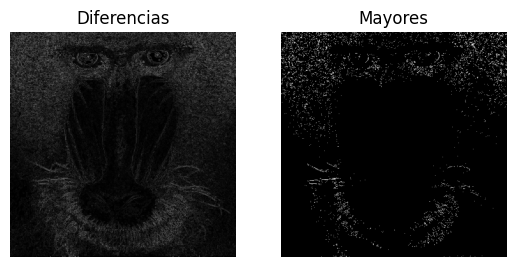

In [ ]:
#Calcula la diferencia entre dos imágenes
#Utiliza la imagen original y la obtenida tras aplicar la gaussiana (creada en la celda dedicada a Sobel)
dif = cv2.absdiff(gris, ggris)

#Visualiza
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Diferencias")
plt.axis("off")
plt.imshow(dif, cmap='gray') 

#Zonas de mayor diferencia tras aplicar umbral
res, imgdif = cv2.threshold(dif, 30, 255, cv2.THRESH_BINARY)
#Visualiza
plt.subplot(1, 2, 2)
plt.title("Mayores")
plt.axis("off")
plt.imshow(imgdif, cmap='gray') 
plt.show()


Webcam y sustracción de fotogramas

In [ ]:
vid = cv2.VideoCapture(0)

#Marca de inicio
disponible = 0 
while(True):      
    # fotograma a fotograma
    ret, frame = vid.read()

    if ret:
        if disponible > 0:
            dif = cv2.absdiff(frame, pframe)        
            # Muestra resultado
            cv2.imshow('Diferencia', dif)    
        else:
            disponible = 1

        #Copia fotograma actual para la diferencia en el siguiente forograma
        pframe = frame.copy()
    # Detenemos pulsado ESC
    if cv2.waitKey(20) == 27:
        break
  
# Libera el objeto de captura
vid.release()
# Destruye ventanas
cv2.destroyAllWindows()

Webcam y sustracción de modelo del fondo

In [37]:
vid = cv2.VideoCapture(0)

# Fondo
# Inicializa la sustracción del fondo con mezcla de gaussianas y detección de sombras
eliminadorFondo = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=50, detectShadows=True)
  
while(True):      
    # fotograma a fotograma
    ret, frame = vid.read()

    if ret:
        # Aplica efecto espejo sobre la entrada
        framem=cv2.flip(frame, 1)

        
        #Con un segundo parámerto se puede definir máscara con zonas a actualizar
        objetos = eliminadorFondo.apply(framem)
        #objetos = eliminadorFondo.apply(framem, objetos, 0)  #No actualiza el fondo
        # Obtiene fondo
        background = eliminadorFondo.getBackgroundImage()

        # Muestra resultado
        cv2.imshow('Fotograma', objetos)
        # Muestra fondo
        cv2.imshow('Fondo', background)
  
   
    # Detenemos pulsado ESC
    if cv2.waitKey(20) == 27:
        break
  
# Libera el objeto de captura
vid.release()
# Destruye ventanas
cv2.destroyAllWindows()


TAREA: Proponer un demostrador que capture las imágenes de la cámara, y les permita exhibir lo aprendido en estas dos prácticas ante quienes no cursen la asignatura :). Es por ello que además de poder mostrar la imagen original de la webcam, permita cambiar de modo, incluyendo al menos dos procesamientos diferentes como resultado de aplicar las funciones de OpenCV trabajadas hasta ahora.


In [2]:
import cv2 as cv
import numpy as np
from collections import deque

def draw_overlay(img, mode):
    out = img.copy()
    return out
def gray_convett(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)
def mode_gray_equalize(img):
    gray_image = gray_convett(img)
    equalize = cv.equalizeHist(gray_image)
    return cv.cvtColor(equalize, cv.COLOR_GRAY2BGR)

def canny_mode(img):
    gray = cv.GaussianBlur(gray_convett(img), (3, 3), 0)
    edges = cv.Canny(gray, 100, 200)
    return cv.cvtColor(edges, cv.COLOR_GRAY2BGR)

def cartoon_mode(img):
    gray = gray_convett(img)
    gray = cv.medianBlur(gray, 5)
    edges = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 4)
    color = cv.bilateralFilter(img, 9, 250, 250)
    cartoon = cv.bitwise_and(color, color, mask=edges)
    return cartoon

if __name__ == "__main__":
    mode = 0
    capture = cv.VideoCapture(0)
    w = int(capture.get(cv.CAP_PROP_FRAME_WIDTH))
    h = int(capture.get(cv.CAP_PROP_FRAME_HEIGHT))

    if not capture.isOpened():
        print("Cannot open camera")
        exit()
    while True:
        ret, frame = capture.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        if mode == 0:
            output = frame
        elif mode == 1:
            output = mode_gray_equalize(frame)
        elif mode == 2:
            output = canny_mode(frame)
        elif mode == 3:
            output = cartoon_mode(frame)
        else:
            output = frame
        
        cv.imshow('frame', output)
        key = cv.waitKey(20) & 0xFF
        if key == 27:                          
            break
        elif key in (ord('m'), ord('M')):
            mode = (mode + 1) % 4
        elif key in (ord('0'), ord('1'), ord('2')):
            mode = int(chr(key))
    # Libera el objeto de captura
capture.release()
# Destruye ventanas
cv.destroyAllWindows()
    


TAREA: Tras ver los vídeos [My little piece of privacy](https://www.niklasroy.com/project/88/my-little-piece-of-privacy), [Messa di voce](https://youtu.be/GfoqiyB1ndE?feature=shared) y [Virtual air guitar](https://youtu.be/FIAmyoEpV5c?feature=shared) proponer un demostrador reinterpretando la parte de procesamiento de la imagen, tomando como punto de partida alguna de dichas instalaciones.